# Exploratory Data Analysis (EDA) for Microplastics Detection

This notebook explores the microplastics detection dataset and tests the base YOLOv8n model performance before any fine-tuning.

We'll focus on:
1. Installing required packages
2. Understanding the dataset statistics
3. Visualizing image samples and annotations
4. Testing the pre-trained YOLOv8n model
5. Analyzing model performance on the dataset

In [21]:
# 1. Install Required Libraries
%pip install ultralytics
%pip install matplotlib seaborn pandas numpy opencv-python pillow

# Import required libraries
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from pathlib import Path
from PIL import Image
from ultralytics import YOLO

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## 2. Dataset Exploration

Let's explore the dataset structure and understand what we're working with.

In [22]:
# Set the data paths
data_path = Path('data')
train_path = data_path / 'train'
valid_path = data_path / 'valid'
test_path = data_path / 'test'

# Function to get dataset statistics
def get_dataset_stats(path, split_name):
    images_path = path / 'images'
    labels_path = path / 'labels'
    
    # Count images
    image_files = list(images_path.glob('*.jpg')) + list(images_path.glob('*.jpeg')) + list(images_path.glob('*.png'))
    n_images = len(image_files)
    
    # Count labels
    label_files = list(labels_path.glob('*.txt'))
    n_labels = len(label_files)
    
    # Count objects (annotations)
    n_objects = 0
    object_sizes = []
    
    for label_file in label_files:
        try:
            with open(label_file, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) >= 5:  # YOLO format has class x y w h
                        n_objects += 1
                        # Extract width and height (normalized)
                        w, h = float(parts[3]), float(parts[4])
                        object_sizes.append((w, h))
        except:
            pass
    
    return {
        'split': split_name,
        'n_images': n_images,
        'n_labeled_images': n_labels,
        'n_objects': n_objects,
        'avg_objects_per_image': n_objects / n_labels if n_labels > 0 else 0,
        'object_sizes': object_sizes
    }

# Get statistics for each split
train_stats = get_dataset_stats(train_path, 'train')
valid_stats = get_dataset_stats(valid_path, 'valid')
test_stats = get_dataset_stats(test_path, 'test')

# Create a summary dataframe
summary_df = pd.DataFrame([
    train_stats,
    valid_stats,
    test_stats
]).drop('object_sizes', axis=1)

print("Dataset Summary:")
print(summary_df)

# Calculate overall statistics
total_images = train_stats['n_images'] + valid_stats['n_images'] + test_stats['n_images']
total_objects = train_stats['n_objects'] + valid_stats['n_objects'] + test_stats['n_objects']
print(f"\nTotal Images: {total_images}")
print(f"Total Objects: {total_objects}")
print(f"Overall Average Objects per Image: {total_objects / total_images:.2f}")

Dataset Summary:
   split  n_images  n_labeled_images  n_objects  avg_objects_per_image
0  train      3226              3226      22427               6.951953
1  valid       928               928       6475               6.977371
2   test       453               453       3204               7.072848

Total Images: 4607
Total Objects: 32106
Overall Average Objects per Image: 6.97


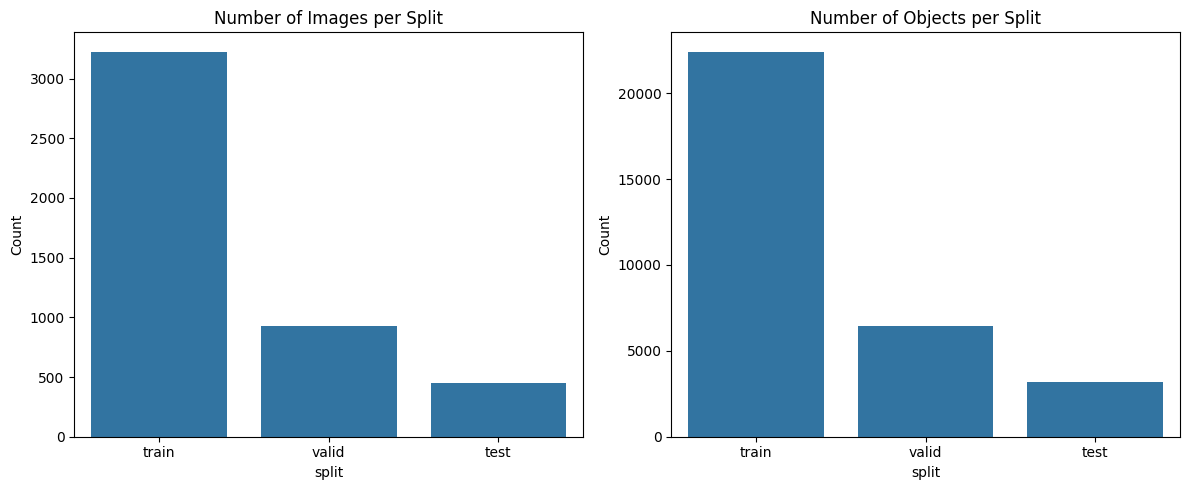

In [23]:
# Visualize the dataset distribution
plt.figure(figsize=(12, 5))

# Plot the number of images per split
plt.subplot(1, 2, 1)
sns.barplot(x='split', y='n_images', data=summary_df)
plt.title('Number of Images per Split')
plt.ylabel('Count')

# Plot the number of objects per split
plt.subplot(1, 2, 2)
sns.barplot(x='split', y='n_objects', data=summary_df)
plt.title('Number of Objects per Split')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

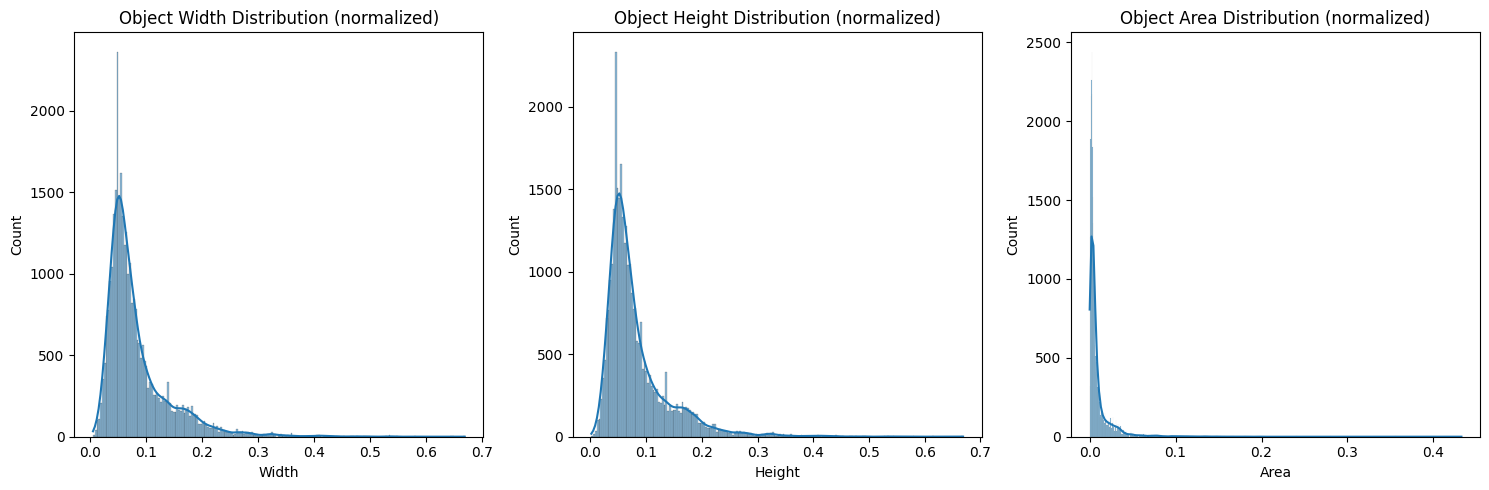

In [24]:
# Analyze object sizes
all_object_sizes = train_stats['object_sizes'] + valid_stats['object_sizes'] + test_stats['object_sizes']

widths = [size[0] for size in all_object_sizes]
heights = [size[1] for size in all_object_sizes]
areas = [w * h for w, h in all_object_sizes]

plt.figure(figsize=(15, 5))

# Plot width distribution
plt.subplot(1, 3, 1)
sns.histplot(widths, kde=True)
plt.title('Object Width Distribution (normalized)')
plt.xlabel('Width')

# Plot height distribution
plt.subplot(1, 3, 2)
sns.histplot(heights, kde=True)
plt.title('Object Height Distribution (normalized)')
plt.xlabel('Height')

# Plot area distribution
plt.subplot(1, 3, 3)
sns.histplot(areas, kde=True)
plt.title('Object Area Distribution (normalized)')
plt.xlabel('Area')

plt.tight_layout()
plt.show()

## 3. Visualize Sample Images with Annotations

Let's visualize some sample images with their annotations to better understand what the model needs to detect.

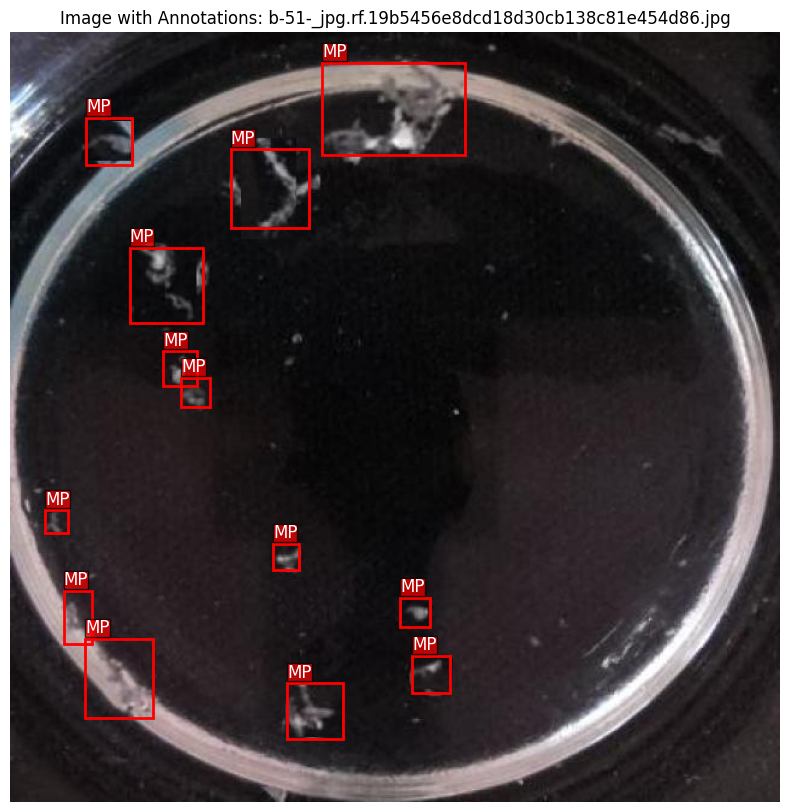

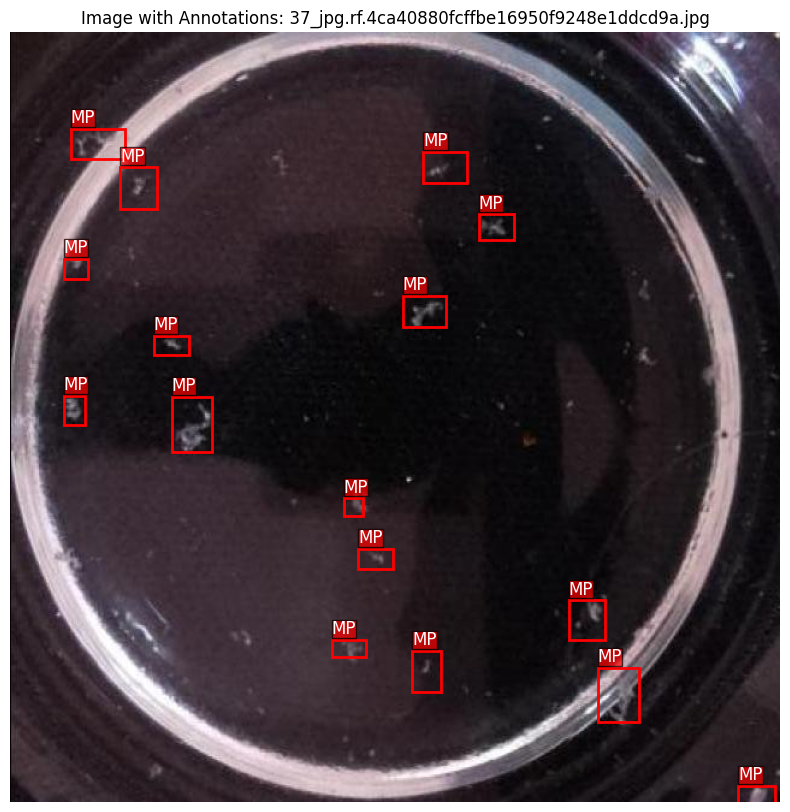

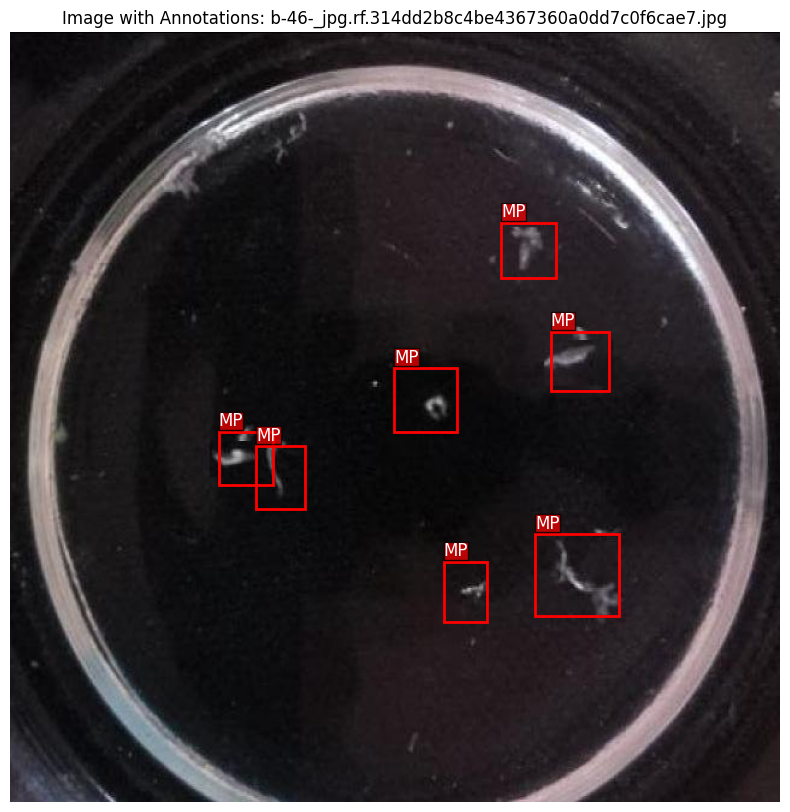

In [25]:
def plot_yolo_annotations(img_path, label_path, figsize=(10, 10)):
    """
    Plot an image with YOLO format annotations
    """
    # Read image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, _ = img.shape
    
    # Create plot
    plt.figure(figsize=figsize)
    plt.imshow(img)
    
    # Read and plot annotations if they exist
    try:
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 5:
                    class_id = int(parts[0])
                    x_center = float(parts[1]) * width
                    y_center = float(parts[2]) * height
                    w = float(parts[3]) * width
                    h = float(parts[4]) * height
                    
                    # Calculate bounding box coordinates
                    x1 = x_center - w/2
                    y1 = y_center - h/2
                    
                    # Create rectangle patch
                    rect = plt.Rectangle((x1, y1), w, h, linewidth=2, edgecolor='r', facecolor='none')
                    plt.gca().add_patch(rect)
                    
                    # Add class label
                    plt.text(x1, y1-5, f"MP", fontsize=12, color='white', 
                             bbox=dict(facecolor='red', alpha=0.7, pad=0))
    except Exception as e:
        plt.title(f"Failed to read annotations: {str(e)}")
    
    plt.axis('off')
    plt.title(f"Image with Annotations: {os.path.basename(img_path)}")
    plt.show()

# Find some sample images from training set
train_images = list((train_path / 'images').glob('*.jpg'))
test_images = list((test_path / 'images').glob('*.jpg'))

# Visualize 3 random samples from training set
np.random.seed(42)  # For reproducibility
sample_train_imgs = np.random.choice(train_images, min(3, len(train_images)), replace=False)

for img_path in sample_train_imgs:
    # Construct label path
    label_path = train_path / 'labels' / f"{img_path.stem}.txt"
    
    plot_yolo_annotations(str(img_path), str(label_path))

## 4. Testing Base YOLOv8n Model

Now, let's test how the pre-trained YOLOv8n model performs on our dataset without any fine-tuning.

In [26]:
# Load pre-trained YOLOv8n model
model = YOLO('yolov8n.pt')

# List of common COCO classes (YOLOv8 is trained on COCO by default)
coco_classes = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 
                'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 
                'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 
                'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 
                'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 
                'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 
                'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 
                'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 
                'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 
                'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

print(f"The base YOLOv8 model is trained to detect {len(coco_classes)} classes from the COCO dataset")
print("Our 'MP' (microplastic) class is not in the pre-trained model's classes")

The base YOLOv8 model is trained to detect 80 classes from the COCO dataset
Our 'MP' (microplastic) class is not in the pre-trained model's classes



image 1/1 c:\Dev\ML_FINAL-PROJ\data\test\images\c-152-_jpg.rf.d1d04af733a845f0b1a4e212ab356487.jpg: 640x640 1 person, 85.6ms
Speed: 19.1ms preprocess, 85.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
image 1/1 c:\Dev\ML_FINAL-PROJ\data\test\images\c-152-_jpg.rf.d1d04af733a845f0b1a4e212ab356487.jpg: 640x640 1 person, 85.6ms
Speed: 19.1ms preprocess, 85.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


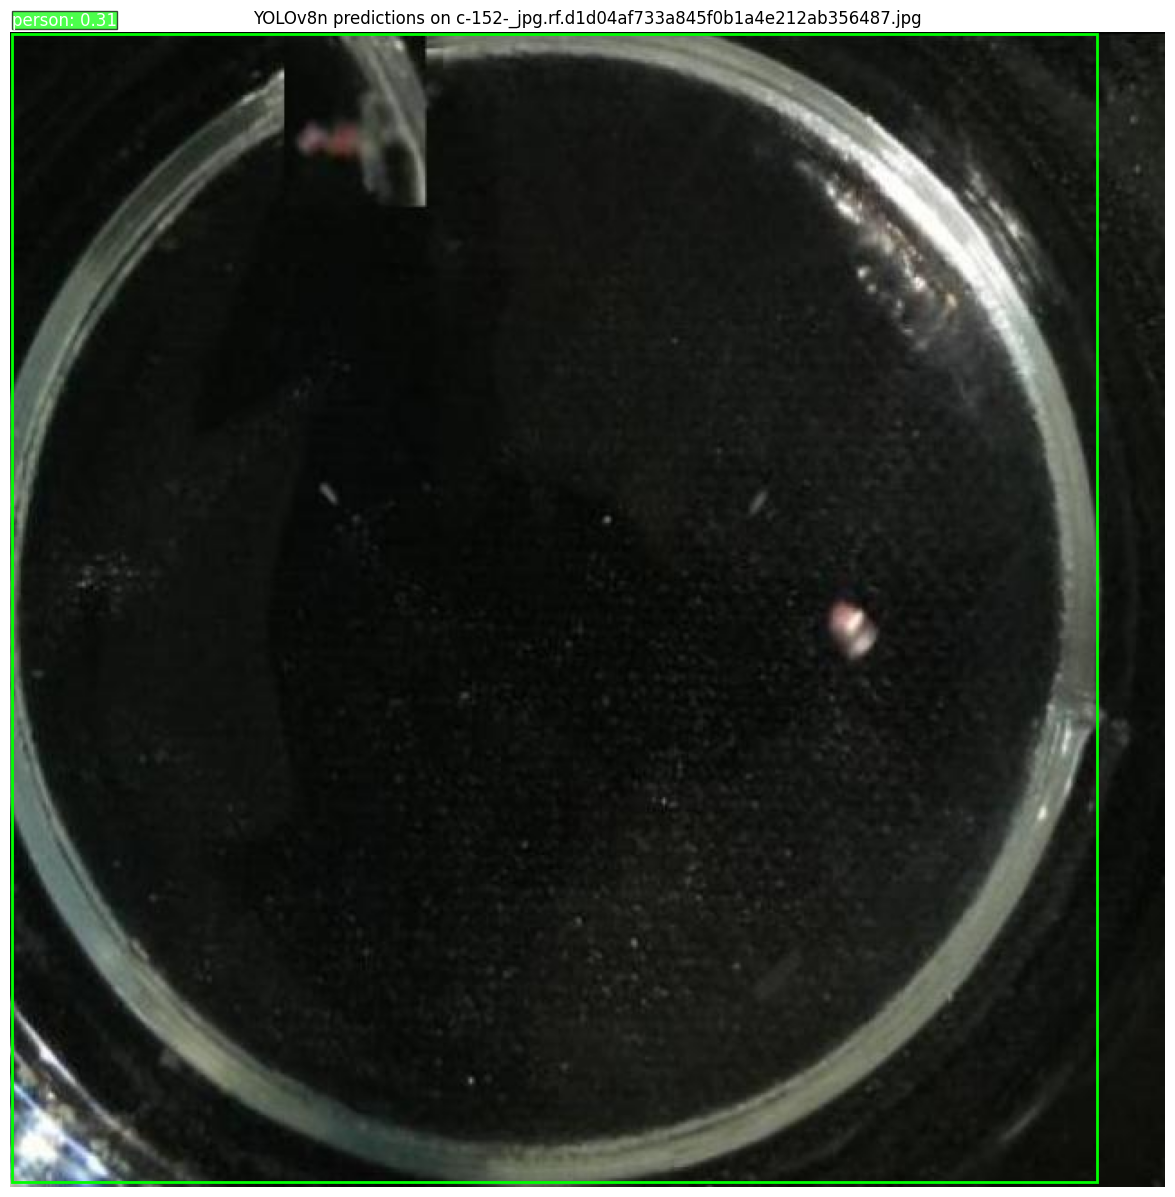

Detected 1 objects in c-152-_jpg.rf.d1d04af733a845f0b1a4e212ab356487.jpg
  1. person with confidence 0.31
--------------------------------------------------

image 1/1 c:\Dev\ML_FINAL-PROJ\data\test\images\f-141-_jpg.rf.2d40a6dcbc12c185710323d36248985e.jpg: 640x640 1 person, 64.0ms
Speed: 2.0ms preprocess, 64.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
image 1/1 c:\Dev\ML_FINAL-PROJ\data\test\images\f-141-_jpg.rf.2d40a6dcbc12c185710323d36248985e.jpg: 640x640 1 person, 64.0ms
Speed: 2.0ms preprocess, 64.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


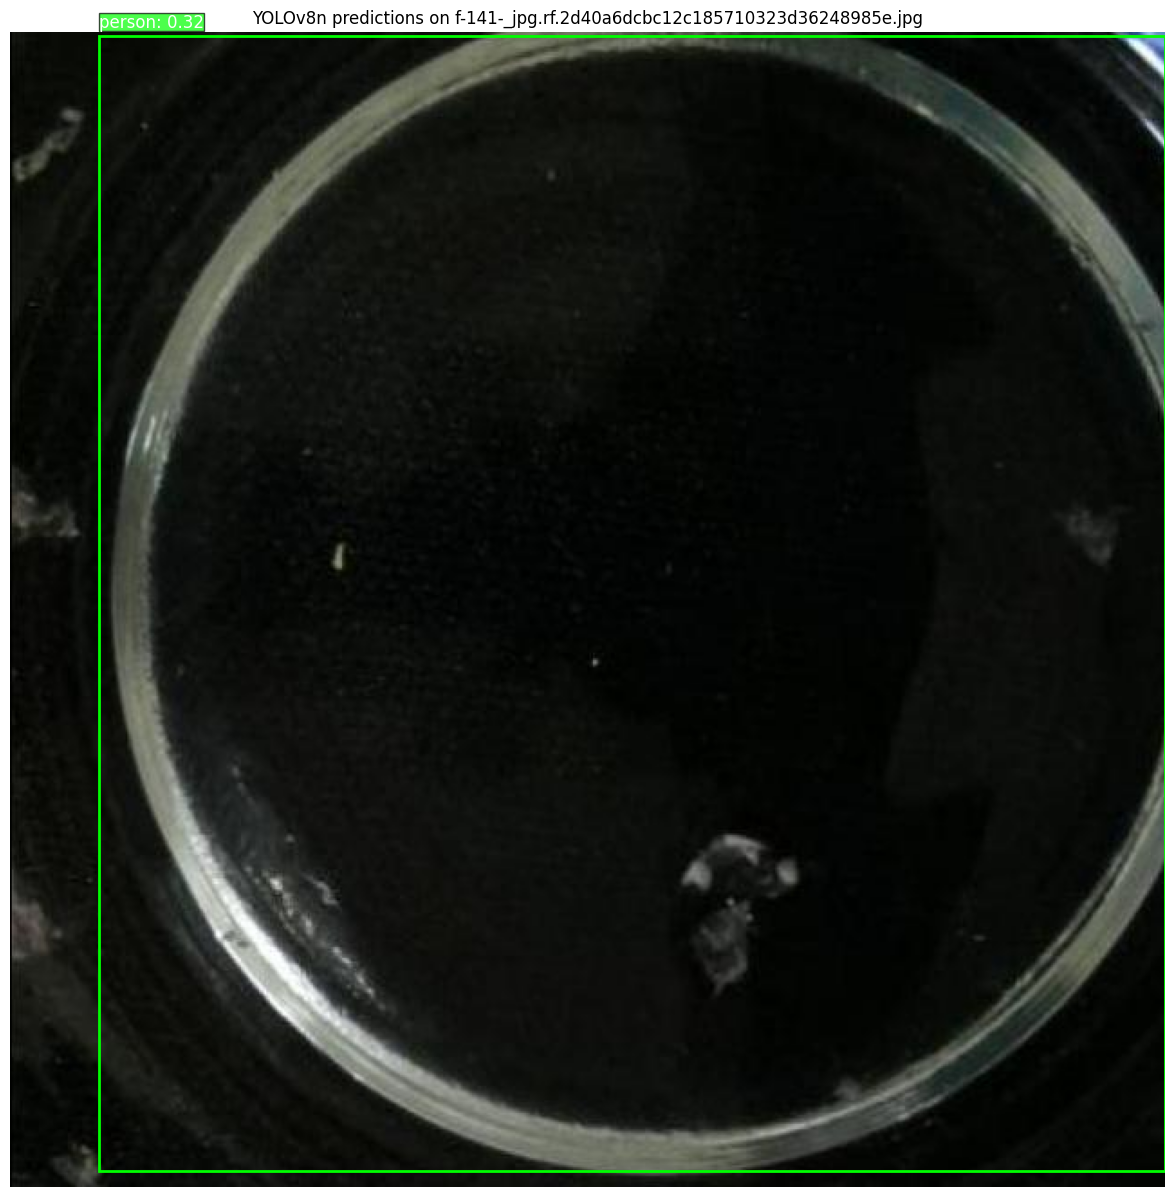

Detected 1 objects in f-141-_jpg.rf.2d40a6dcbc12c185710323d36248985e.jpg
  1. person with confidence 0.32
--------------------------------------------------

image 1/1 c:\Dev\ML_FINAL-PROJ\data\test\images\d-25-_jpg.rf.94677f21639440091614070360e9240d.jpg: 640x640 1 umbrella, 61.4ms
Speed: 2.5ms preprocess, 61.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
image 1/1 c:\Dev\ML_FINAL-PROJ\data\test\images\d-25-_jpg.rf.94677f21639440091614070360e9240d.jpg: 640x640 1 umbrella, 61.4ms
Speed: 2.5ms preprocess, 61.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


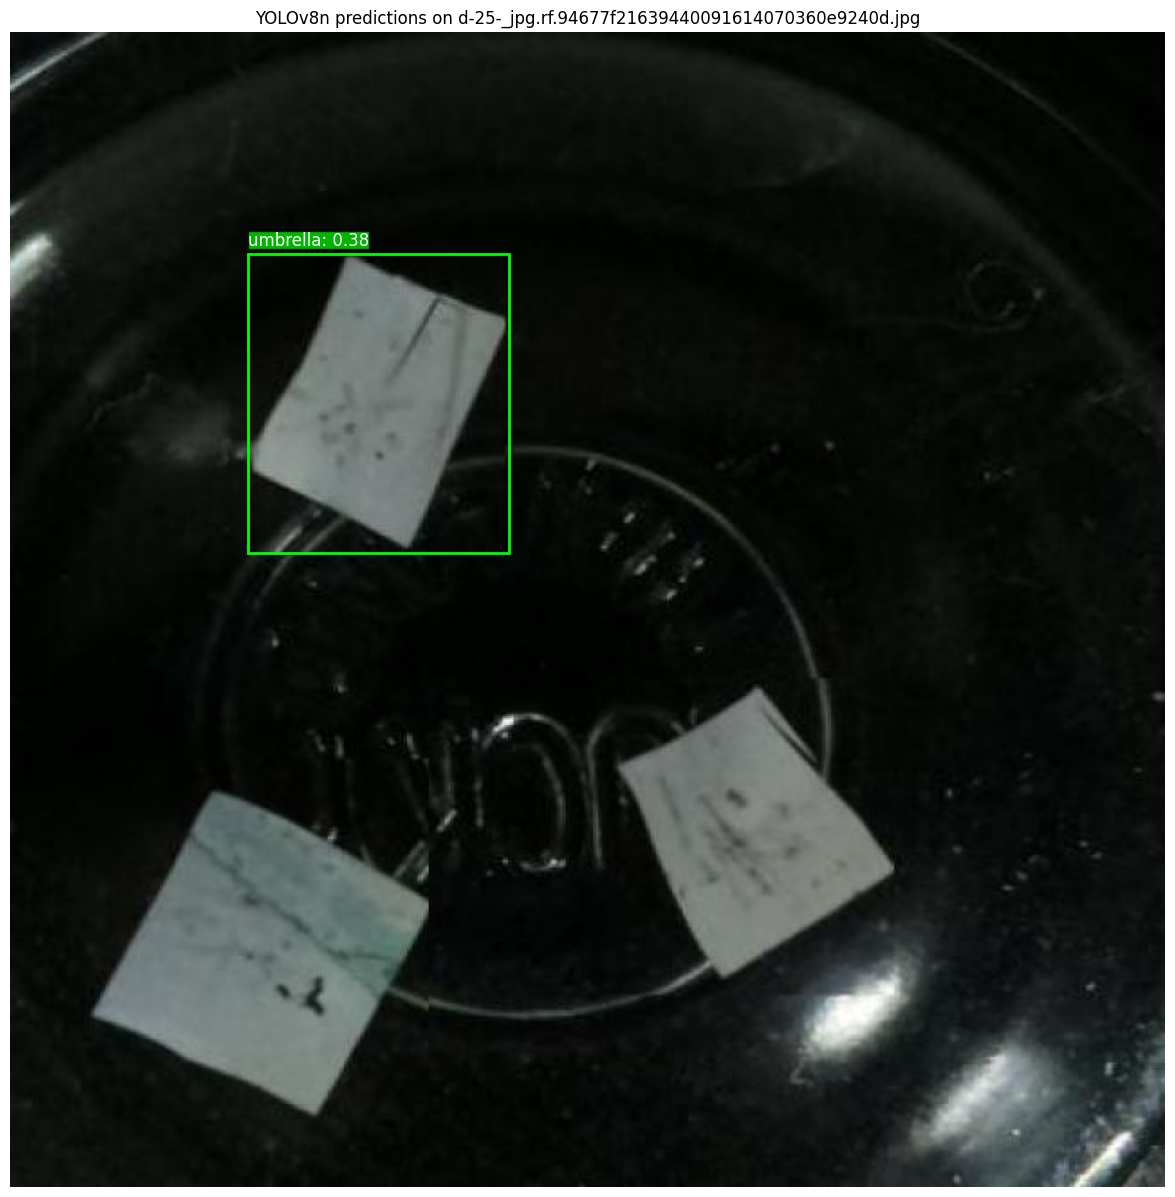

Detected 1 objects in d-25-_jpg.rf.94677f21639440091614070360e9240d.jpg
  1. umbrella with confidence 0.38
--------------------------------------------------

image 1/1 c:\Dev\ML_FINAL-PROJ\data\test\images\f-164-_jpg.rf.888027c7f7a8b9719496388f2f4cc13a.jpg: 640x640 (no detections), 114.4ms
Speed: 2.7ms preprocess, 114.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
image 1/1 c:\Dev\ML_FINAL-PROJ\data\test\images\f-164-_jpg.rf.888027c7f7a8b9719496388f2f4cc13a.jpg: 640x640 (no detections), 114.4ms
Speed: 2.7ms preprocess, 114.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


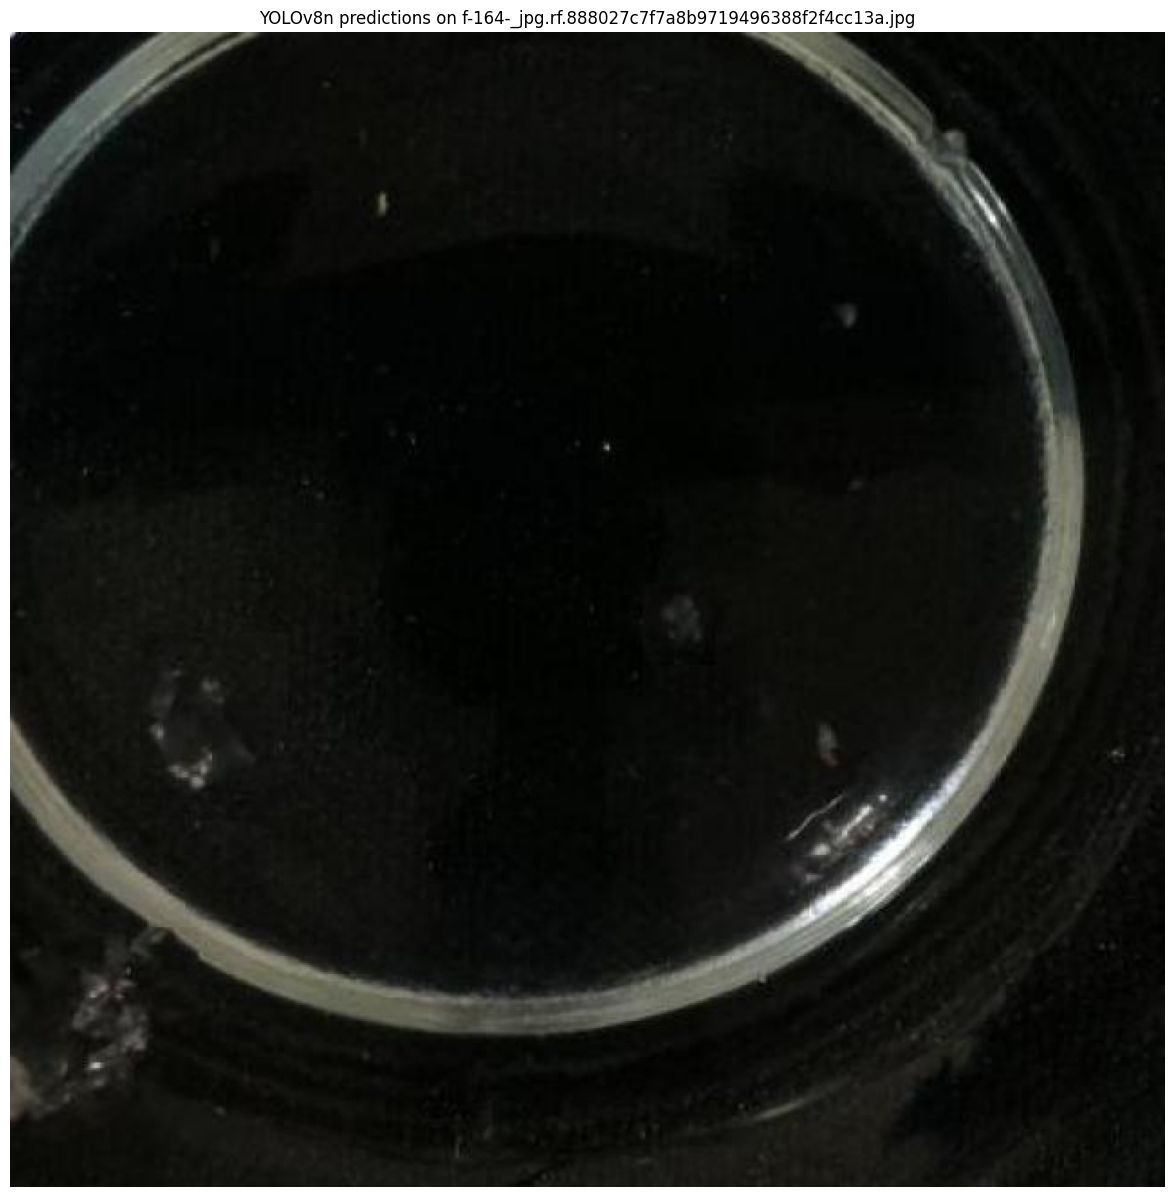

Detected 0 objects in f-164-_jpg.rf.888027c7f7a8b9719496388f2f4cc13a.jpg
--------------------------------------------------

image 1/1 c:\Dev\ML_FINAL-PROJ\data\test\images\f-136-_jpg.rf.3b0ab2b08a6d5b5f53ab19ebf1cccd4c.jpg: 640x640 (no detections), 56.4ms
Speed: 2.2ms preprocess, 56.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
image 1/1 c:\Dev\ML_FINAL-PROJ\data\test\images\f-136-_jpg.rf.3b0ab2b08a6d5b5f53ab19ebf1cccd4c.jpg: 640x640 (no detections), 56.4ms
Speed: 2.2ms preprocess, 56.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


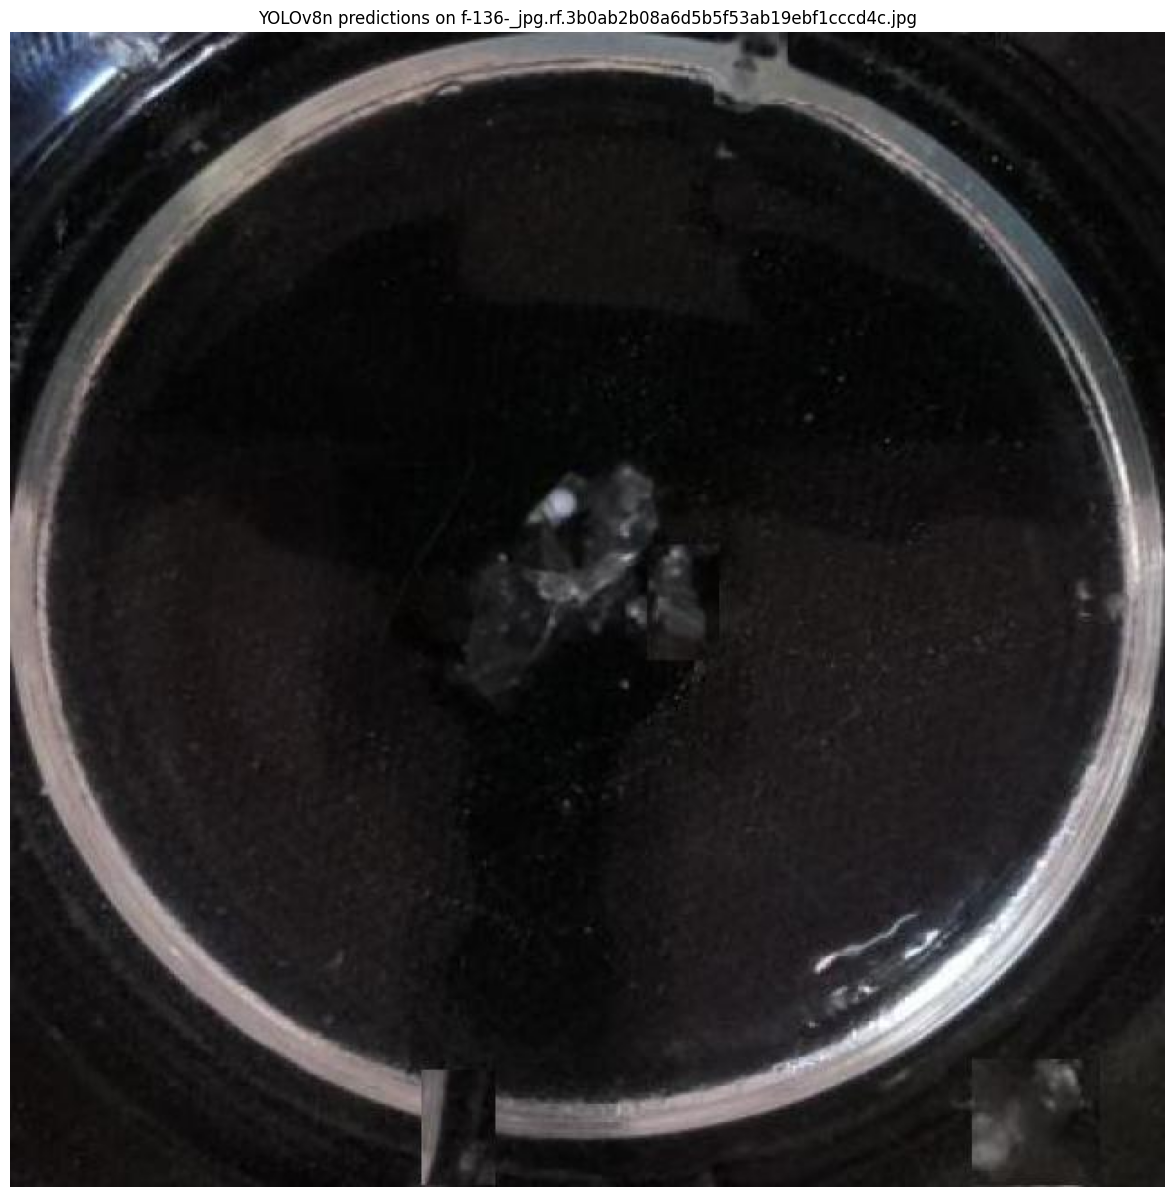

Detected 0 objects in f-136-_jpg.rf.3b0ab2b08a6d5b5f53ab19ebf1cccd4c.jpg
--------------------------------------------------


In [30]:
# Function to run inference and show results
def test_model_on_images(model, image_paths, conf_threshold=0.25, figsize=(15, 15)):
    """
    Run the model on sample images and display the results
    """
    for img_path in image_paths:
        # Run inference
        results = model(img_path, conf=conf_threshold)[0]
        
        # Get the image
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Create plot
        plt.figure(figsize=figsize)
        plt.imshow(img)
        plt.title(f"YOLOv8n predictions on {os.path.basename(img_path)}")
        
        # Plot predictions
        boxes = results.boxes
        for i, box in enumerate(boxes):
            # Get box coordinates
            x1, y1, x2, y2 = box.xyxy[0]
            confidence = float(box.conf[0])  # Convert tensor to float
            cls = int(box.cls[0])
            
            # Draw bounding box
            width = x2 - x1
            height = y2 - y1
            rect = plt.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='lime', facecolor='none')
            plt.gca().add_patch(rect)
            
            # Add class label and confidence
            class_name = coco_classes[cls] if cls < len(coco_classes) else f"Class {cls}"
            plt.text(x1, y1-5, f"{class_name}: {confidence:.2f}", fontsize=12, color='white',
                    bbox=dict(facecolor='lime', alpha=0.7, pad=0))
        
        plt.axis('off')
        plt.show()
        
        print(f"Detected {len(boxes)} objects in {os.path.basename(img_path)}")
        if len(boxes) > 0:
            for i, box in enumerate(boxes):
                cls = int(box.cls[0])
                confidence = float(box.conf[0])  # Convert tensor to float
                class_name = coco_classes[cls] if cls < len(coco_classes) else f"Class {cls}"
                print(f"  {i+1}. {class_name} with confidence {confidence:.2f}")
        print("-" * 50)

# Test on a few sample images from test set
sample_test_imgs = np.random.choice(test_images, min(5, len(test_images)), replace=False)
test_model_on_images(model, sample_test_imgs)

## 5. Model Performance Analysis

Based on the results above, we can analyze how well the base YOLOv8n model performs on our microplastics dataset.

In [28]:
# Let's systematically evaluate the model on our test set
def evaluate_base_model(model, test_images_path, annotations_path, conf_threshold=0.25, max_samples=50):
    """
    Evaluate the base model performance by comparing with ground truth annotations
    """
    # List all test images
    image_files = list(test_images_path.glob('*.jpg'))
    
    # Limit the number of samples for faster evaluation
    if max_samples and max_samples < len(image_files):
        np.random.seed(42)  # For reproducibility
        image_files = np.random.choice(image_files, max_samples, replace=False).tolist()
    
    # Statistics
    total_true_positives = 0
    total_false_positives = 0
    total_ground_truth = 0
    total_predictions = 0
    
    # Process each image
    for img_path in image_files:
        # Get corresponding annotation path
        annotation_path = annotations_path / f"{img_path.stem}.txt"
        
        # Load ground truth
        gt_boxes = []
        if annotation_path.exists():
            with open(annotation_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        # YOLO format: class x_center y_center width height
                        # Convert to xyxy format for easier comparison
                        img = cv2.imread(str(img_path))
                        height, width = img.shape[:2]
                        
                        x_center = float(parts[1]) * width
                        y_center = float(parts[2]) * height
                        w = float(parts[3]) * width
                        h = float(parts[4]) * height
                        
                        x1 = x_center - w/2
                        y1 = y_center - h/2
                        x2 = x_center + w/2
                        y2 = y_center + h/2
                        
                        gt_boxes.append([x1, y1, x2, y2])
        
        # Run model prediction
        results = model(img_path, conf=conf_threshold)[0]
        pred_boxes = results.boxes.xyxy.cpu().numpy()
        
        # Count statistics
        total_ground_truth += len(gt_boxes)
        total_predictions += len(pred_boxes)
        
        # For this simple evaluation, we'll just count how many predictions the model makes
        # compared to ground truth, without doing proper IoU-based evaluation
    
    # Calculate metrics (just basic comparison)
    results = {
        'num_images_evaluated': len(image_files),
        'total_ground_truth_objects': total_ground_truth,
        'total_predicted_objects': total_predictions,
        'ratio_pred_gt': total_predictions / total_ground_truth if total_ground_truth > 0 else 0
    }
    
    return results

# Run the evaluation
test_results = evaluate_base_model(
    model, 
    test_path / 'images', 
    test_path / 'labels',
    max_samples=30  # Limit to 30 images for faster evaluation
)

# Print the results
print("Base YOLOv8n Model Performance on Test Set:")
for key, value in test_results.items():
    print(f"{key}: {value}")

# Interpret the results
if test_results['total_predicted_objects'] == 0:
    print("\nInterpretation: The pre-trained model doesn't detect any objects that match our microplastics.")
    print("This is expected since microplastics are not in the COCO dataset classes.")
elif test_results['ratio_pred_gt'] < 0.5:
    print("\nInterpretation: The pre-trained model detects significantly fewer objects than exist in our dataset.")
    print("The model needs fine-tuning to learn our specific 'MP' class.")
elif test_results['ratio_pred_gt'] > 1.5:
    print("\nInterpretation: The pre-trained model is detecting many more objects than our ground truth.")
    print("These are likely false positives or detecting different objects than the microplastics we're interested in.")
else:
    print("\nInterpretation: The pre-trained model is detecting a similar number of objects as our ground truth.")
    print("However, these are likely not the same objects or the correct class. Fine-tuning is necessary.")


image 1/1 c:\Dev\ML_FINAL-PROJ\data\test\images\f-128-_jpg.rf.0edbce42183387c76633f56c7c54af33.jpg: 640x640 1 person, 67.4ms
Speed: 8.7ms preprocess, 67.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
image 1/1 c:\Dev\ML_FINAL-PROJ\data\test\images\f-128-_jpg.rf.0edbce42183387c76633f56c7c54af33.jpg: 640x640 1 person, 67.4ms
Speed: 8.7ms preprocess, 67.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


image 1/1 c:\Dev\ML_FINAL-PROJ\data\test\images\193_jpg.rf.6b2f0bcb8fa21e180405b939f6c3b540.jpg: 640x640 (no detections), 58.1ms
Speed: 2.0ms preprocess, 58.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\Dev\ML_FINAL-PROJ\data\test\images\193_jpg.rf.6b2f0bcb8fa21e180405b939f6c3b540.jpg: 640x640 (no detections), 58.1ms
Speed: 2.0ms preprocess, 58.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\Dev\ML_FINAL-PROJ\data\test\images\f-140-_jpg.rf.acc4985c75572ffbacc7aebc68472b18.jpg:

## 6. Image Resolution Analysis

Let's analyze the resolution of images in our dataset to understand if there's any preprocessing needed when fine-tuning the model.

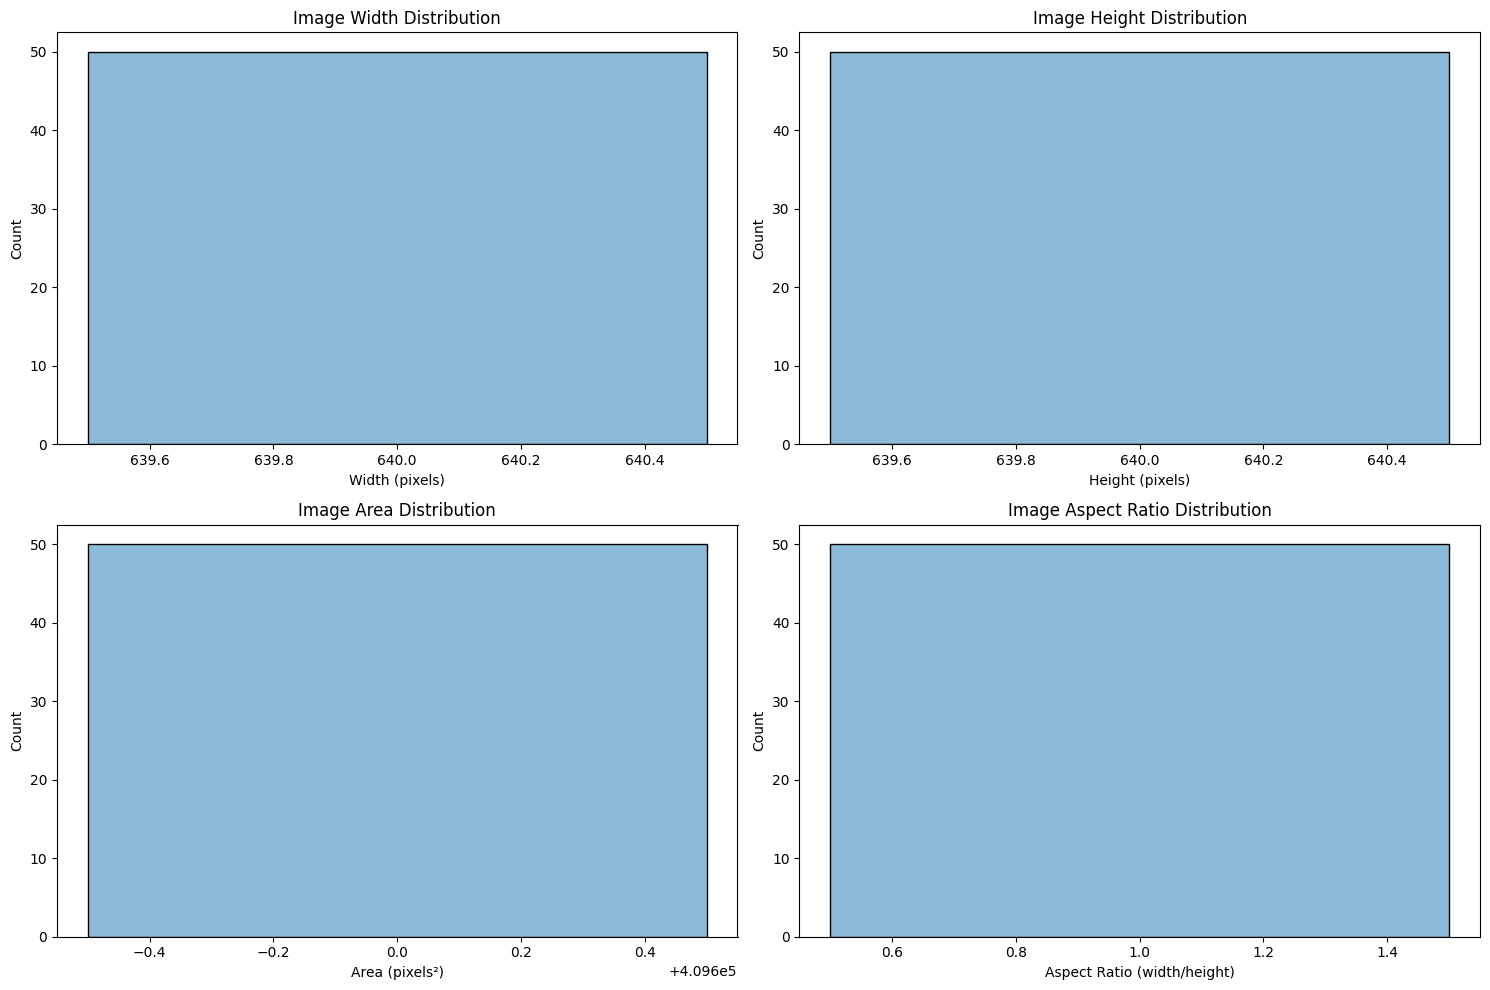

Image Resolution Statistics:
min_width: 640.00
max_width: 640.00
mean_width: 640.00
min_height: 640.00
max_height: 640.00
mean_height: 640.00
min_area: 409600.00
max_area: 409600.00
mean_area: 409600.00
min_aspect_ratio: 1.00
max_aspect_ratio: 1.00
mean_aspect_ratio: 1.00


In [29]:
# Analyze image resolutions
def analyze_image_resolutions(image_paths, max_samples=50):
    """
    Analyze the resolution distribution of images
    """
    # Limit the number of samples for faster processing
    if max_samples and max_samples < len(image_paths):
        np.random.seed(42)  # For reproducibility
        image_paths = np.random.choice(image_paths, max_samples, replace=False).tolist()
    
    # Collect resolutions
    resolutions = []
    aspect_ratios = []
    
    for img_path in image_paths:
        img = Image.open(img_path)
        width, height = img.size
        resolutions.append((width, height))
        aspect_ratios.append(width / height)
    
    # Convert to arrays for easier analysis
    widths = np.array([r[0] for r in resolutions])
    heights = np.array([r[1] for r in resolutions])
    areas = widths * heights
    aspect_ratios = np.array(aspect_ratios)
    
    # Summary statistics
    resolution_stats = {
        'min_width': widths.min(),
        'max_width': widths.max(),
        'mean_width': widths.mean(),
        'min_height': heights.min(),
        'max_height': heights.max(),
        'mean_height': heights.mean(),
        'min_area': areas.min(),
        'max_area': areas.max(),
        'mean_area': areas.mean(),
        'min_aspect_ratio': aspect_ratios.min(),
        'max_aspect_ratio': aspect_ratios.max(),
        'mean_aspect_ratio': aspect_ratios.mean()
    }
    
    # Visualize
    plt.figure(figsize=(15, 10))
    
    # Width distribution
    plt.subplot(2, 2, 1)
    sns.histplot(widths, kde=True)
    plt.title('Image Width Distribution')
    plt.xlabel('Width (pixels)')
    
    # Height distribution
    plt.subplot(2, 2, 2)
    sns.histplot(heights, kde=True)
    plt.title('Image Height Distribution')
    plt.xlabel('Height (pixels)')
    
    # Area distribution
    plt.subplot(2, 2, 3)
    sns.histplot(areas, kde=True)
    plt.title('Image Area Distribution')
    plt.xlabel('Area (pixels²)')
    
    # Aspect ratio distribution
    plt.subplot(2, 2, 4)
    sns.histplot(aspect_ratios, kde=True)
    plt.title('Image Aspect Ratio Distribution')
    plt.xlabel('Aspect Ratio (width/height)')
    
    plt.tight_layout()
    plt.show()
    
    return resolution_stats

# Collect all images
all_images = (list((train_path / 'images').glob('*.jpg')) + 
             list((valid_path / 'images').glob('*.jpg')) + 
             list((test_path / 'images').glob('*.jpg')))

# Analyze resolutions
resolution_stats = analyze_image_resolutions(all_images)

# Print summary
print("Image Resolution Statistics:")
for key, value in resolution_stats.items():
    print(f"{key}: {value:.2f}")

## 7. Conclusion and Next Steps

Based on our exploratory data analysis, we've learned:

1. **Dataset Overview**: 
   - We have analyzed the distribution of images and annotations across train, validation, and test sets
   - We've visualized the object size distributions

2. **Base Model Performance**:
   - The pre-trained YOLOv8n model does not recognize microplastics as it's not in the COCO dataset classes
   - We need to fine-tune the model to detect our specific "MP" class

3. **Image Characteristics**:
   - We've analyzed the resolution distribution, which will help determine appropriate preprocessing steps

**Next Steps**:
1. Fine-tune the YOLOv8n model on our microplastics dataset
2. Compare performance before and after fine-tuning
3. Optimize model parameters based on the characteristics of our dataset